# Try to detect S-phase purely from histone H2B fluorescence signal intensity

### Rationale:
During S-phase, the DNA in the cell replicates which means that the number of histones it recruits for effective nuclear packaging should double in amount. 

### Problem: 
The histone H2B reporter protein is under control of a constitutively active viral promoter (CMV: cytomegalovirus) which transcribes huge amounts of the protein regardless its need in the cell.

### Expectation: 
Unlikely to work, but it would be nice to at least show whether there is **any dependence**!

### Steps to take: 
+ choose a representative movie: GV0800, pos0
+ extract the ID's of those cells which are non-root and non-leaf
+ return their data: frame, label, nucleus_size, fluo_signal_sum for the whole duration of their life
+ plot the data: nucleus size, fluo_signal_sum, average_intensity, normalised_average_intensity

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import sys
sys.path.append("../")

from tqdm import tqdm
from scipy.interpolate import UnivariateSpline
from Movie_Analysis_Pipeline.Single_Movie_Processing.Server_Movies_Paths import Get_MDCK_Movies_Paths


In [3]:
hdf5_file = "/Volumes/lowegrp/Data/Kristina/Cells_MDCK/GV0800/pos0/HDF/segmented.hdf5"

### Shortlist non-root, non-leaf cells:



In [13]:
def Shortlist_True_Dividers(hdf5_file):
    """ """
    
    dividers = []
    
    with h5py.File(hdf5_file, 'r') as f:
        print (len(f["tracks"]["obj_type_1"]["LBEPR"]))
        for cell, progeny in zip(f["tracks"]["obj_type_1"]["LBEPR"], f["tracks"]["obj_type_1"]["Ch_Ch_Gen_CCT"]):
            if int(cell[4]) != 0:
                if int(progeny[0]) != 0 and int(progeny[1]) != 0:
                    dividers.append(int(cell[0]))
    return dividers


dividers = Shortlist_True_Dividers(hdf5_file=hdf5_file)
cell_count = len(dividers)
print (cell_count)

1921
301


In an example movie (GV0800, pos0), out of 1921 total cells in the 'LBEPR' table there were 301 non-root non-leaf cells, which corresponds to 15.67%

### Extract the data for each individual cell:

Data to extract: frame, nucleus_size, fluo_signal_sum

In [11]:
def Extract_Cell_Data(hdf5_file, dividers):
    
    nucleus, fsignal = [[] for _ in range(cell_count)], [[] for _ in range(cell_count)]

    with h5py.File(hdf5_file, 'r') as f:
        counter = 0
    
        for enum, cell in enumerate(f["tracks"]["obj_type_1"]["LBEPR"]):    
            if int(cell[0]) in dividers:
                cell_map = f["tracks"]["obj_type_1"]["map"][enum]
                
                for trk in f["tracks"]["obj_type_1"]["tracks"][cell_map[0] : cell_map[1]]:
                    # Exclude dummy objects:
                    if trk <= 0:
                        continue
                    # Exclude non-interphase nuclei:
                    if f["objects"]["obj_type_1"]["labels"][trk][0] != 0:
                        continue
                    
                    # Append the nucleus_size & fluo_signal_sum:
                    nuc = f["objects"]["obj_type_1"]["nucleus_size"][trk]
                    sig = f["objects"]["obj_type_1"]["fluo_signal_sum"][trk]
                    
                    if nuc != 0 and sig != 0:
                        nucleus[counter].append(nuc)
                        fsignal[counter].append(sig)
                        
                counter += 1
                    
    return nucleus, fsignal


nucleus, fsignal = Extract_Cell_Data(hdf5_file=hdf5_file, dividers=dividers)

In [12]:
print (len(nucleus))
print (len(fsignal))
for nuc, sig in zip(nucleus, fsignal):
    print (len(nuc), len(sig), len(nuc) == len(sig))

301
301
824 824 True
595 595 True
500 500 True
472 472 True
438 438 True
401 401 True
426 426 True
397 397 True
392 392 True
408 408 True
407 407 True
401 401 True
412 412 True
404 404 True
324 324 True
371 371 True
389 389 True
393 393 True
388 388 True
387 387 True
376 376 True
375 375 True
375 375 True
372 372 True
366 366 True
363 363 True
365 365 True
359 359 True
357 357 True
358 358 True
309 309 True
361 361 True
359 359 True
350 350 True
353 353 True
338 338 True
353 353 True
352 352 True
342 342 True
340 340 True
347 347 True
342 342 True
349 349 True
343 343 True
341 341 True
338 338 True
310 310 True
330 330 True
310 310 True
326 326 True
329 329 True
332 332 True
331 331 True
316 316 True
314 314 True
330 330 True
317 317 True
321 321 True
326 326 True
318 318 True
221 221 True
321 321 True
313 313 True
317 317 True
315 315 True
321 321 True
318 318 True
315 315 True
312 312 True
319 319 True
313 313 True
316 316 True
314 314 True
288 288 True
310 310 True
311 311 True
309 

### Plot the graphs for individual cells:

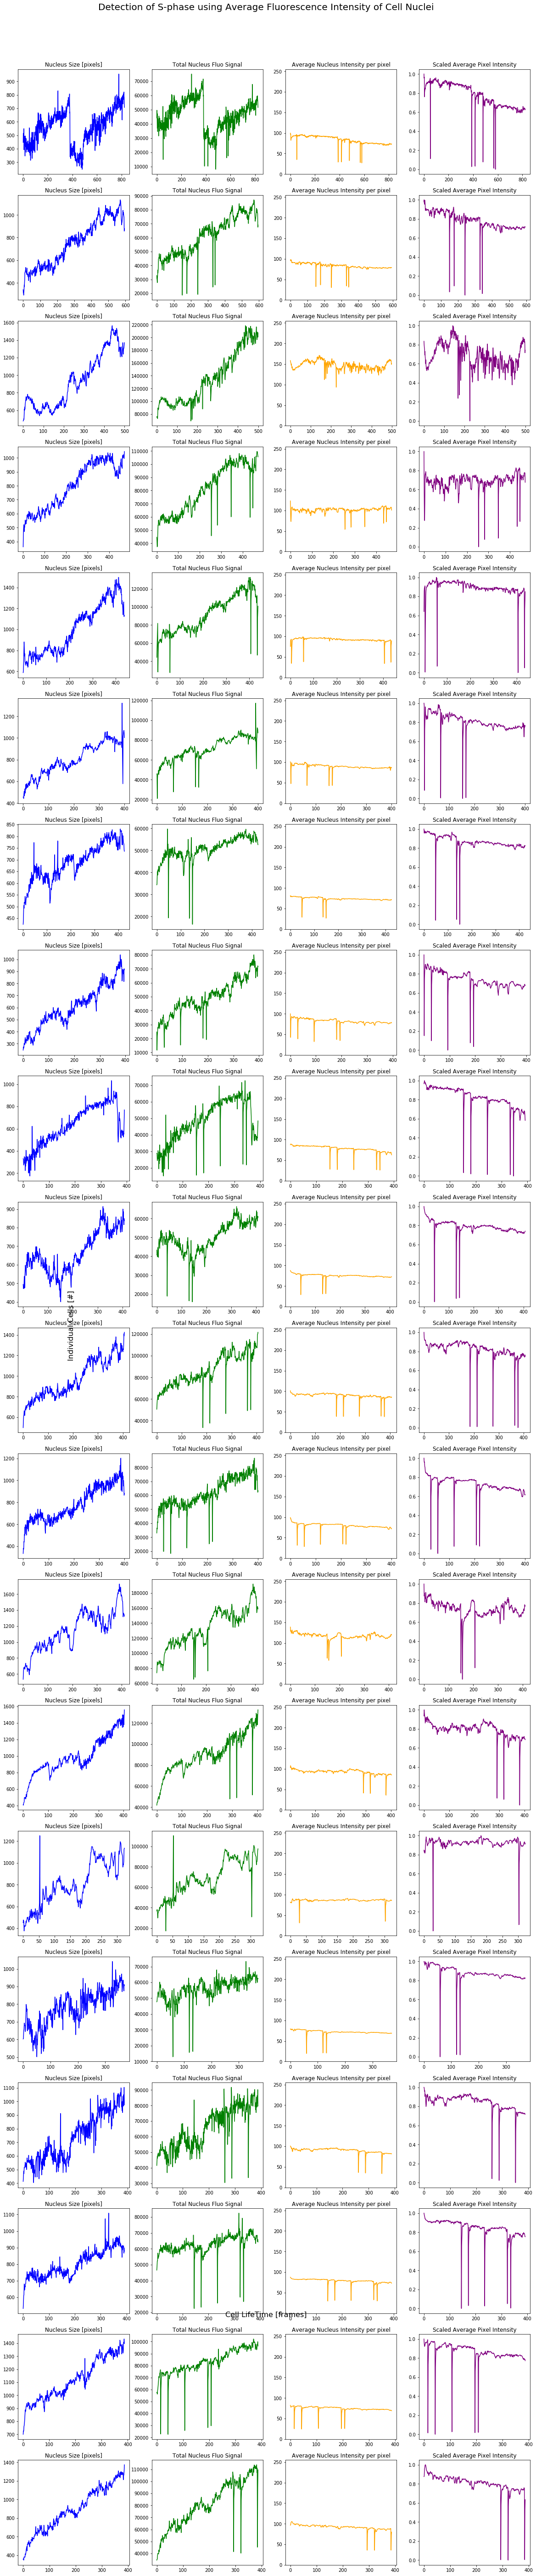

In [17]:
fig, axs = plt.subplots(figsize=(20, 100), nrows=20, ncols=4)
fig.suptitle(t="Detection of S-phase using Average Fluorescence Intensity of Cell Nuclei", x=0.5, y=0.9, fontsize=20)
fig.text(x=0.5, y=0.2, s="Cell LifeTime [frames]", ha='center', fontsize=16)
fig.text(x=0.2, y=0.5, s="Individual Cells [#]", va='center', rotation='vertical', fontsize=16)


for enum, (nuc, sig) in enumerate(zip(nucleus, fsignal)):
    
    if enum < 20:
        avg = [s/n for s, n in zip(sig, nuc)]
        scl = [(item - np.min(avg)) / (np.max(avg) - np.min(avg)) for item in avg]
        
        axs[enum, 0].plot(nuc, color="blue")
        axs[enum, 0].set_title("Nucleus Size [pixels]")

        axs[enum, 1].plot(sig, color="green")
        axs[enum, 1].set_title("Total Nucleus Fluo Signal")

        
        axs[enum, 2].plot(avg, color="orange")
        axs[enum, 2].set_title("Average Nucleus Intensity per pixel")
        axs[enum, 2].set_ylim(0, 255)
            
        axs[enum, 3].plot(scl, color="purple")
        axs[enum, 3].set_title("Scaled Average Pixel Intensity")
        axs[enum, 3].set_ylim(-0.05, 1.05)

plt.show()
plt.close()

### Plot the normalised (scaled 0-1) average nucleus fluorescence intensity for all cells on a single graph

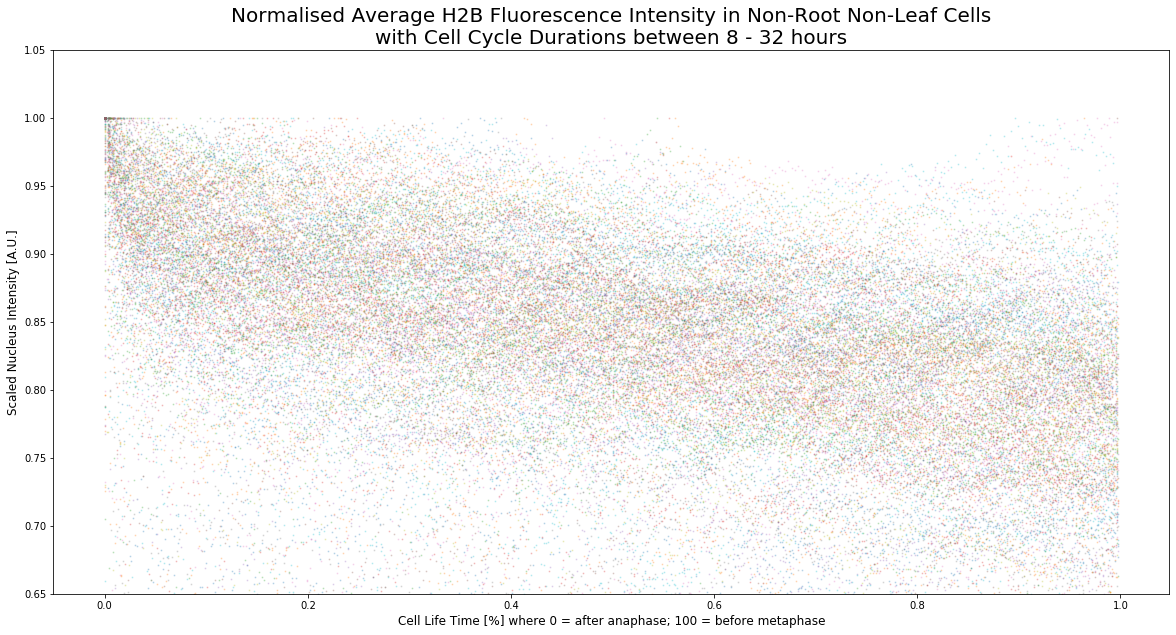

'\n_ = plt.figure(figsize=(20, 10))\n\nfor enum, (nuc, sig) in enumerate(zip(nucleus, fsignal)):\n    \n    avg = [s/n for s, n in zip(sig, nuc)]\n    scl_y = [(item - np.min(avg)) / (np.max(avg) - np.min(avg)) for item in avg]\n    scl_x = [item / len(avg) for item in range(len(avg))]\n    \n    # Only plot cells living between 8 - 32 hours:\n    if 120 <= len(avg) <= 480:\n        s = UnivariateSpline(x=scl_x, y=scl_y, s=1)\n        plt.plot(scl_x, s(scl_x), alpha=0.2)\n\nplt.title("Normalised Average H2B Fluorescence Intensity in Non-Root Non-Leaf Cells\nwith Cell Cycle Durations between 8 - 32 hours", fontsize=20)\nplt.xlabel("Cell Life Time [%] where 0 = after anaphase; 100 = before metaphase", fontsize=12)\nplt.ylabel("Scaled Nucleus Intensity [A.U.]", fontsize=12)\nplt.show()\nplt.close()\n'

In [29]:
fig, axs = plt.subplots(figsize=(20, 10), nrows=3, ncols=1)

for enum, (nuc, sig) in enumerate(zip(nucleus, fsignal)):
    
    avg = [s/n for s, n in zip(sig, nuc)]
    scl_y = [(item - np.min(avg)) / (np.max(avg) - np.min(avg)) for item in avg]
    scl_x = [item / len(avg) for item in range(len(avg))]
    
    # Only plot cells living between 8 - 32 hours:
    if 120 <= len(avg) <= 480:
        axs[0].plot(scl_x, scl_y, alpha=0.2)
        axs[1].scatter(x=scl_x, y=scl_y, s=1, alpha=0.3)
        axs[2].scatter(x=scl_x, y=scl_y, s=1, alpha=0.3)
        
    
plt.title("Normalised Average H2B Fluorescence Intensity in Interphase Non-Root Non-Leaf Cells\nwith Cell Cycle Durations between 8 - 32 hours", fontsize=20)
plt.xlabel("Cell Life Time [%] where 0 = after anaphase; 100 = before metaphase", fontsize=12)
plt.ylabel("Scaled Nucleus Intensity [A.U.]", fontsize=12)
plt.ylim(0.65, 1.05)
plt.show()
plt.close()

"""
_ = plt.figure(figsize=(20, 10))

for enum, (nuc, sig) in enumerate(zip(nucleus, fsignal)):
    
    avg = [s/n for s, n in zip(sig, nuc)]
    scl_y = [(item - np.min(avg)) / (np.max(avg) - np.min(avg)) for item in avg]
    scl_x = [item / len(avg) for item in range(len(avg))]
    
    # Only plot cells living between 8 - 32 hours:
    if 120 <= len(avg) <= 480:
        s = UnivariateSpline(x=scl_x, y=scl_y, s=1)
        plt.plot(scl_x, s(scl_x), alpha=0.2)

plt.title("Normalised Average H2B Fluorescence Intensity in Non-Root Non-Leaf Cells\nwith Cell Cycle Durations between 8 - 32 hours", fontsize=20)
plt.xlabel("Cell Life Time [%] where 0 = after anaphase; 100 = before metaphase", fontsize=12)
plt.ylabel("Scaled Nucleus Intensity [A.U.]", fontsize=12)
plt.show()
plt.close()
"""




92
92


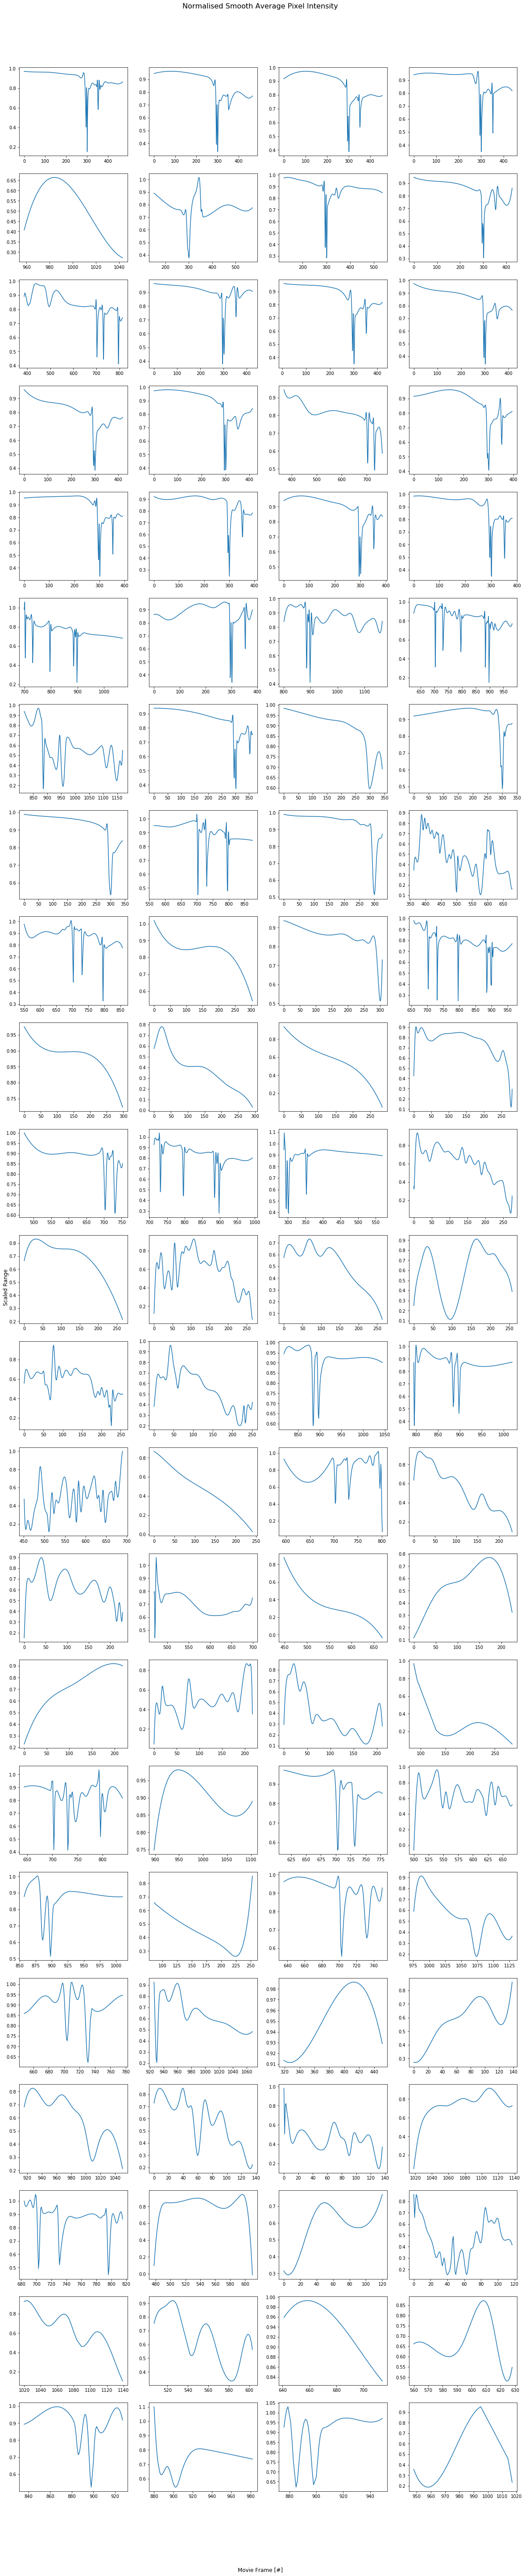

In [163]:
frm, smt = Process_Data(frames, nucleus, fsignal)

print (len(frm))
print (len(smt))

fig, axs = plt.subplots(figsize=(20, 100), nrows=23, ncols=4)
fig.suptitle(t="Normalised Smooth Average Pixel Intensity", x=0.5, y=0.9, fontsize=16)
fig.text(x=0.5, y=0.1, s="Movie Frame [#]", ha='center', fontsize=12)
fig.text(x=0.1, y=0.5, s="Scaled Range", va='center', rotation='vertical', fontsize=12)


for enum, (x, y) in enumerate(zip(frm, smt)):
    axs[enum // 4, enum % 4].plot(x, y)
plt.show()